In [37]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, GPT2Tokenizer


In [39]:
SENTENCES = []

with open("p6/p6_podcast_filtered_sentences.txt", "r") as file:
    SENTENCES = file.readlines()

SENTENCES = [s[:-1] for s in SENTENCES] # Trim off the \n at the end of each line. 
print(f'{len(SENTENCES)} Total Sentences')

SENTENCES = SENTENCES[:25]
SENTENCES

132 Total Sentences


["Alright, I knew that one wasn't cool.",
 'Fifth grade was the last year I can remember believing that the world needed more of two.',
 "That's That's the most fun way to describe being raised fundamentalist.",
 'And then I went to 6th grade.',
 'I could somehow be cool, or I could somehow be invisible.',
 'And then we would read our three favorite answers that they gave.',
 'My sheet ended up in the hands of a kid.',
 "I don't remember his name, but he was one of the coolest and meanest kids I'd ever met.",
 'The first question was, what is your favorite movie?',
 'And the other kids had said, Scream Universal Soldier.',
 "And I remember thinking, we're eleven.",
 'How are you seeing r rated movies?',
 'My answer was Beauty and the Beast, which I maintain has held up better than those other two movies.',
 'But I could not make that argument effectively at the time.',
 'The next question he chose to read was, where would you like to travel?',
 'And the other kids had said, Australia, 

In [40]:
'''
GPT-2 family:
"gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"

GPT-Neo family:
"EleutherAI/gpt-neo-125M", "EleutherAI/gpt-neo-1.3B", "EleutherAI/gpt-neo-2.7B",
"EleutherAI/gpt-j-6B", "EleutherAI/gpt-neox-20b"

OPT family:
"facebook/opt-125m", "facebook/opt-350m", "facebook/opt-1.3b", "facebook/opt-2.7b",
"facebook/opt-6.7b", "facebook/opt-13b", "facebook/opt-30b", "facebook/opt-66b"
'''

PROMPT = "Once upon a time"
MODEL_PATH = "EleutherAI/gpt-neo-125M"

# For graphing. 
MODEL_NAME = ""
if "gpt-neo-125" in MODEL_PATH:
    MODEL_NAME = "GPT-Neo 125M"
elif "gpt-neo-1.3B" in MODEL_PATH:
    MODEL_NAME = "GPT-Neo 1.3B"
elif "gpt2-mediuam" in MODEL_PATH:
    MODEL_NAME = "GPT2 345M"
elif "gpt2-large" in MODEL_PATH:
    MODEL_NAME = "GPT2 774M"
elif "gpt2-xl" in MODEL_PATH:
    MODEL_NAME = "GPT2 1.5B"
else:
    MODEL_NAME = "GPT2 117M"


tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M") # TinyStories, GPTNeo
# tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

model = AutoModelForCausalLM.from_pretrained(MODEL_PATH)
model.eval()

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_fe

#### Get the hidden layer activations from PROMPT (incrementally giving the sentence to the LLM to record outputs)

In [41]:
def get_num_layers(model):
    """
    Returns the number of *transformer blocks* for any HuggingFace causal LM.
    """
    cfg = model.config
    for field in ["num_hidden_layers", "n_layer", "num_layers"]:
        if hasattr(cfg, field):
            return getattr(cfg, field)
        
    # fallback — count modules
    if hasattr(model, "transformer") and hasattr(model.transformer, "h"):
        return len(model.transformer.h)
    
    raise ValueError("Could not infer number of transformer layers.")


def normalize_hidden_states(all_h, num_layers):
    """
    Ensures the returned list corresponds exactly to transformer block outputs,
    excluding the embedding layer.
    """
    # HF always: hidden_states[0] = embeddings
    if len(all_h) == num_layers + 1:
        return all_h[1:]   # strip embeddings
    elif len(all_h) == num_layers:
        return all_h       # some models do not return embeddings
    else:
        raise ValueError(f"Unexpected number of hidden states: {len(all_h)}")

def collect_sentence_activations(sentence, model, tokenizer):
    """
    Returns activations as a tensor of shape:
        (num_tokens, num_layers, hidden_dim)
    """
    # Tokenize input sentence
    input_ids = tokenizer(sentence, return_tensors="pt").input_ids
    num_tokens = input_ids.shape[1]

    num_layers = get_num_layers(model)
    hidden_dim = model.config.hidden_size

    activations = torch.zeros((num_tokens, num_layers, hidden_dim))

    # Iterate over prefix length
    for step in range(num_tokens):
        current_ids = input_ids[:, :step+1]

        with torch.no_grad():
            outputs = model(current_ids, output_hidden_states=True)

        # normalize hidden states
        layer_states = normalize_hidden_states(outputs.hidden_states, num_layers)

        # capture the LAST TOKEN activations for each layer
        for layer_idx, h in enumerate(layer_states):
            activations[step, layer_idx, :] = h[0, -1, :]

    return activations


sentence_activations = []
num_layers = len(model.transformer.h)
for sentence in SENTENCES:
    sentence_activation = collect_sentence_activations(sentence, model, tokenizer)

    sentence_activations.append(sentence_activation)
    print(sentence_activation.shape)   # (num_tokens, num_layers, hidden_dim)



torch.Size([10, 12, 768])
torch.Size([19, 12, 768])
torch.Size([14, 12, 768])
torch.Size([9, 12, 768])
torch.Size([13, 12, 768])
torch.Size([13, 12, 768])
torch.Size([11, 12, 768])
torch.Size([23, 12, 768])
torch.Size([11, 12, 768])
torch.Size([11, 12, 768])
torch.Size([9, 12, 768])
torch.Size([8, 12, 768])
torch.Size([21, 12, 768])
torch.Size([12, 12, 768])
torch.Size([16, 12, 768])
torch.Size([13, 12, 768])
torch.Size([10, 12, 768])
torch.Size([15, 12, 768])
torch.Size([12, 12, 768])
torch.Size([20, 12, 768])
torch.Size([13, 12, 768])
torch.Size([12, 12, 768])
torch.Size([19, 12, 768])
torch.Size([10, 12, 768])
torch.Size([11, 12, 768])


In [42]:
# Print dimensions and outputs for verifcation. 
input_ids = tokenizer(SENTENCES[0], return_tensors="pt").input_ids
num_tokens = input_ids.shape[1]
decoded_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
print("\nInput sentence decoded:")
print(decoded_text)

print(f"Processed {num_tokens} tokens from input sentence")
print(f"Each token has activations for {num_layers} layers")
print(f"Example activation shape: {sentence_activations[0][0][0].shape}")




Input sentence decoded:
Alright, I knew that one wasn't cool.
Processed 10 tokens from input sentence
Each token has activations for 12 layers
Example activation shape: torch.Size([768])


In [43]:
print(len(sentence_activations[3]))

9


#### Curvature Calculations

In [44]:
sentence_curvatures = [] # List of tuples (average_curvature_across_sentence, change_in_curvature_across_sentence)
for response_activations in sentence_activations:
    num_generated = len(response_activations)
    print(f"num_generated = {num_generated}")

    # Get the adjacency vectors (a hidden layer p, and the difference between the word k and k+1 at layer p) 
    adjacent_states = [] # [ [v_p{ki+1 - ki, ...}], [v_p+1{}], [v_p+2{}], ... ]
    for p in range(num_layers):
        layer_diffs = []
        for k in range(num_generated - 1):
            diff = response_activations[k+1][p] - response_activations[k][p]
            layer_diffs.append(diff)
        adjacent_states.append(layer_diffs)

    # Validate the shape is correct
    print(f"Len of Adj. States {len(adjacent_states)}")                # num_layers
    print(f"Shape of Adj. States[0] {len(adjacent_states[0])}")             # num_tokens - 1
    print(f"Shape of Adj. States [0][0] {adjacent_states[0][0].shape}") 

    # Calculate the curvature between words k and k+1
    curvatures = [] # (num_layers x num_tokens - 1 - 1) -> [ [c_p{(k, k+1), (k+1, k+2)...}], [c_p+1{}], ...  ]
    for p in range(num_layers):  # Loop through each layer, p
        p_curvatures = []
        for k in range(len(adjacent_states[0])-1): # then for every k, k+1 get the curvature between those vectors. 
            adjacency_product = np.dot(adjacent_states[p][k+1], adjacent_states[p][k])
            norm_product = np.linalg.norm(adjacent_states[p][k+1]) * np.linalg.norm(adjacent_states[p][k])
            curvature = np.degrees(math.acos((adjacency_product / norm_product))) # Convert to degrees. 
            p_curvatures.append(curvature)

        curvatures.append(p_curvatures)


    print(f"Len of curvatures = {len(curvatures)}")
    print(f"Len of a curvature element = {len(curvatures[0])}")

    # At a layer, P. Across all words in the sentence
    average_curvatures_across_sentence = [(np.sum(c) / len(c)) for c in curvatures] # sum of the curvatures for all words at layer p / total number of words
    # Layer P - Layer 1
    change_in_curvatures_across_sentence = [c - average_curvatures_across_sentence[0] for c in average_curvatures_across_sentence]

    sentence_curvatures.append((average_curvatures_across_sentence, change_in_curvatures_across_sentence))
    print("--------------------------------------------------")




num_generated = 10
Len of Adj. States 12
Shape of Adj. States[0] 9
Shape of Adj. States [0][0] torch.Size([768])
Len of curvatures = 12
Len of a curvature element = 8
--------------------------------------------------
num_generated = 19
Len of Adj. States 12
Shape of Adj. States[0] 18
Shape of Adj. States [0][0] torch.Size([768])
Len of curvatures = 12
Len of a curvature element = 17
--------------------------------------------------
num_generated = 14
Len of Adj. States 12
Shape of Adj. States[0] 13
Shape of Adj. States [0][0] torch.Size([768])
Len of curvatures = 12
Len of a curvature element = 12
--------------------------------------------------
num_generated = 9
Len of Adj. States 12
Shape of Adj. States[0] 8
Shape of Adj. States [0][0] torch.Size([768])
Len of curvatures = 12
Len of a curvature element = 7
--------------------------------------------------
num_generated = 13
Len of Adj. States 12
Shape of Adj. States[0] 12
Shape of Adj. States [0][0] torch.Size([768])
Len of curv

/var/folders/2k/6js25dxx5_3d034p40m62gkh0000gn/T/ipykernel_75005/849679360.py:25: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  adjacency_product = np.dot(adjacent_states[p][k+1], adjacent_states[p][k])


#### Computes the average change in curvature across all sentences for each layer P.

In [45]:
print(len(sentence_curvatures[0][1])) # [sentence, (avg curvs, change_across_sentence)]

# np.mean(, axis=?)
# [layer, num_sentences] -> at a layer, there is the change in curvature for each sentence at that layer. 
curv_per_layer = np.zeros((num_layers, len(SENTENCES)))
for sentence, curv_info in enumerate(sentence_curvatures):
    change_across_sentence = curv_info[1]
    for layer, delta_curv in enumerate(change_across_sentence):
        curv_per_layer[layer][sentence] = delta_curv


avg_curv_per_layer_across_all_sentences = np.mean(curv_per_layer, axis=-1)
var_curv_per_layer_across_all_sentences = np.var(curv_per_layer, axis=-1)

12


#### Graph the change in curvature across each layer across all sentences

gpt-neo_125m_25_curvature_change.png


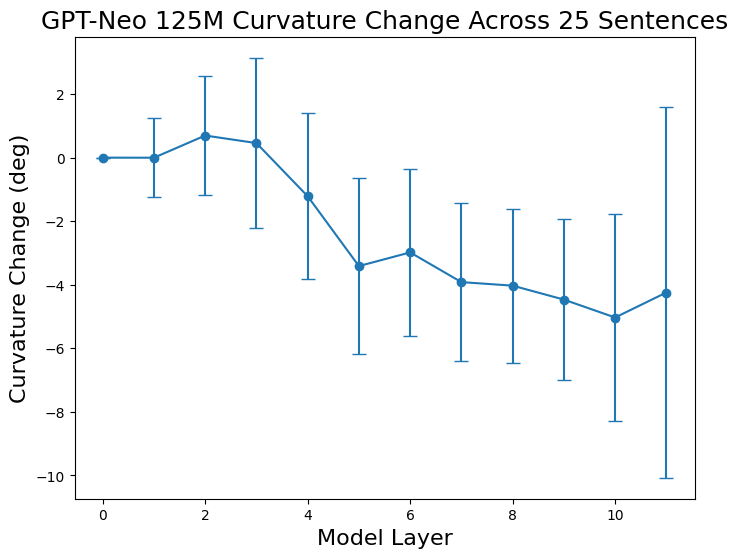

In [46]:
std_dev = np.sqrt(var_curv_per_layer_across_all_sentences)

x = np.arange(len(avg_curv_per_layer_across_all_sentences))

plt.figure(figsize=(8, 6))
plt.errorbar(
    x,
    avg_curv_per_layer_across_all_sentences,
    yerr=std_dev,
    fmt='o-',
    capsize=5,
)
plt.ylabel("Curvature Change (deg)", fontsize=16)
plt.xlabel("Model Layer", fontsize=16)
plt.title(f"{MODEL_NAME} Curvature Change Across {len(SENTENCES)} Sentences", fontsize=18)

fig_name = f'{MODEL_NAME.lower().replace(" ", "_")}_{len(SENTENCES)}_curvature_change.png'
print(fig_name)
plt.savefig(fig_name)